In [1]:
import os
import time
import json
import numpy as np
from scipy.stats import kendalltau
from scipy.spatial.distance import cdist
from itertools import chain
from src.lexrank import degree_centrality_scores

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import ray

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

import ot

In [2]:
DATASET = DATASETS[1]
DATA_DIR = 'data'
EMBEDDINGS_DIR = os.path.join(DATA_DIR, 'fasttext')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.set_default_tensor_type(torch.DoubleTensor) # Change to torch.gpu later
import matplotlib.pyplot as plt

In [4]:
import sinkhorn_pointcloud as spc
from layers import SinkhornDistance
from geomloss import SamplesLoss

In [5]:
# D_in = 300
# D_out = 10

# M = torch.randn(D_in, D_out, requires_grad=True)

# sinkhorn = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

# criterion = nn.MSELoss()
# optimizer = optim.Adam([M], lr=1e-2)

# for topic_id in TOPICS[DATASET][:1]:
#     topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET), topic_id, encoded=True)
#     document_embs, summary_embs, indices, pyr_scores, _ = extract(topic)
    
#     D = torch.tensor(document_embs)
#     idx = np.arange(len(indices))

#     for i in idx:
#         np.random.shuffle(idx)
        
#         optimizer.zero_grad()
        
#         S = torch.tensor(summary_embs[indices[i][0]:indices[i][1]])
#         dist = sinkhorn(torch.mm(D, M), torch.mm(S, M))

#         y_pred = torch.exp(-dist)
#         y = torch.tensor(pyr_scores[i])
        
#         loss = criterion(y_pred, y)
#         print(loss.item())
        
#         loss.backward()
        
#         optimizer.step()

Try out:
- Play with the parameters: D_out, blur in SampleLoss, learning rate
- Batching
- sigmoid(10 * x)

In [56]:
D_in = 300
D_out = 10

M = torch.randn(D_in, D_out, requires_grad=True)

sinkhorn = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

model = nn.Sigmoid()
criterion = nn.BCELoss()
optimizer = optim.SGD([M], lr=0.001)

total_loss = []

for topic_id in TOPICS[DATASET][:1]:
    topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET), topic_id, encoded=True)
    document_embs, summary_embs, indices, pyr_scores, _ = extract(topic)
    
    D = torch.tensor(document_embs)
    
    n = range(len(indices))
    data = [(i, j, int(pyr_scores[i] > pyr_scores[j])) for i in n for j in n if i != j]
    np.random.shuffle(data)
    
    print(len(data))

    for t in data:
        optimizer.zero_grad()
        
        ii = indices[t[0]]
        jj = indices[t[1]]
        
        S1 = torch.tensor(summary_embs[ii[0]:ii[1]])
        S2 = torch.tensor(summary_embs[jj[0]:jj[1]])
        
        dist1 = sinkhorn(torch.mm(D, M), torch.mm(S1, M))
        dist2 = sinkhorn(torch.mm(D, M), torch.mm(S2, M))
        
        y = torch.tensor(t[2], dtype=torch.double)
        y_hat = model(dist2 - dist1)
        
        loss = criterion(y_hat, y)
        total_loss.append(loss.item())
        print(total_loss[-1])
        
        loss.backward()
        
        optimizer.step()

3422
6.784135884958623
2.524563878261533


KeyboardInterrupt: 

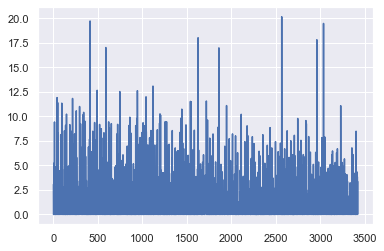

In [48]:
plt.plot(total_loss);

In [49]:
M_ = M.detach().numpy()

In [50]:
topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET), TOPICS[DATASET][0], encoded=True)
document_embs, summary_embs, indices, pyr_scores, _ = extract(topic)

In [51]:
m = np.argsort(-np.array(pyr_scores))

In [53]:
D = torch.tensor(document_embs)
metric = lambda i: sinkhorn(D, torch.tensor(summary_embs[i[0]:i[1]]))
kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

-0.24099913862244315

In [23]:
D = torch.tensor(document_embs @ M_)
metric = lambda i: sinkhorn(D, torch.tensor(summary_embs[i[0]:i[1]] @ M_))
kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

-0.2595076476565825

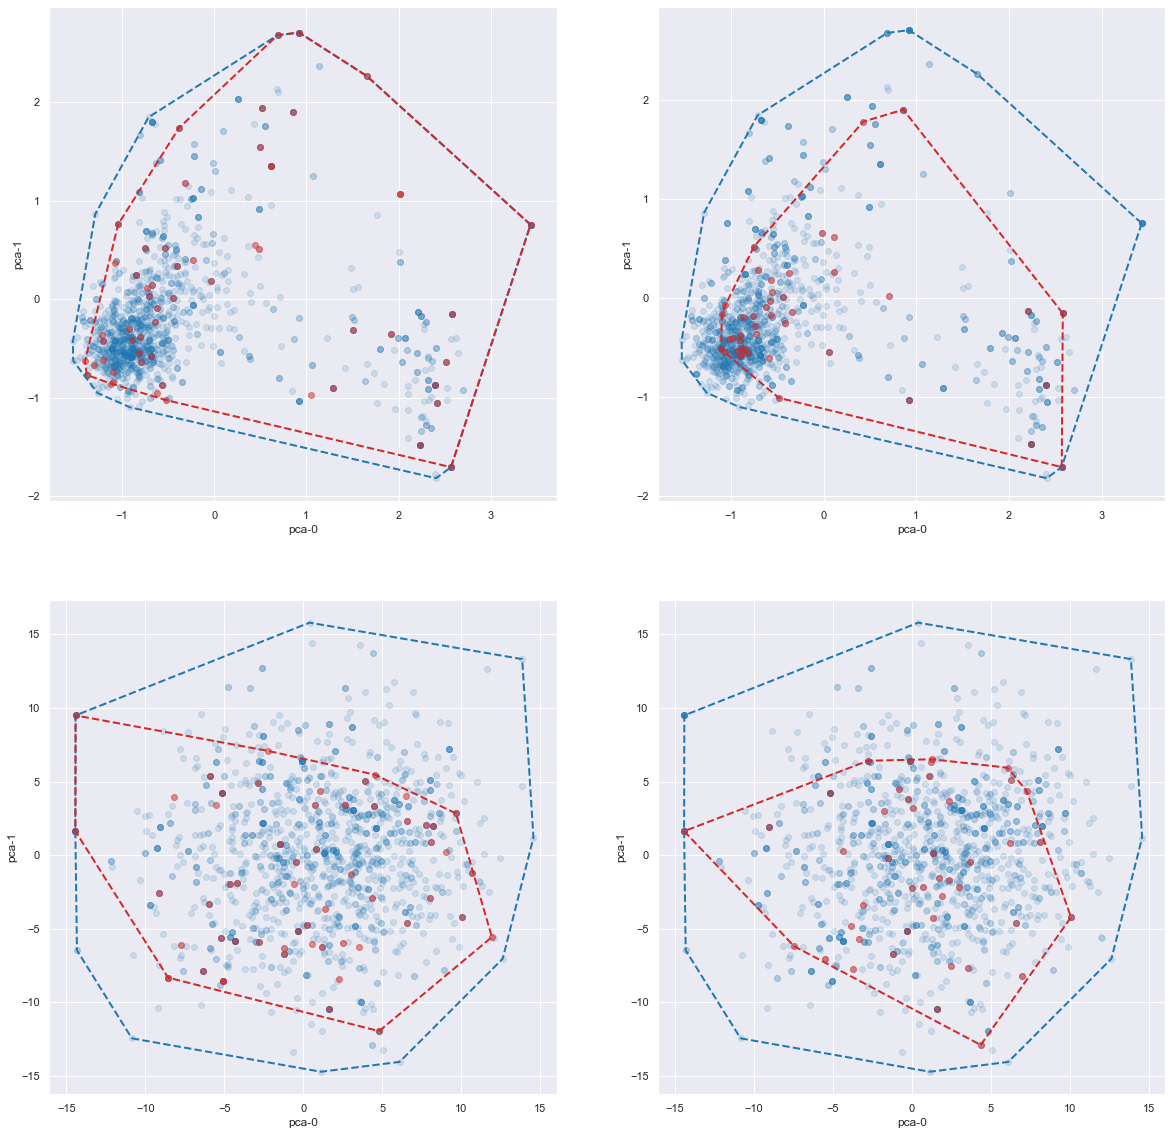

In [52]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

fig = plt.figure(figsize=(20,20))

b = 1
w = -1

ax1 = fig.add_subplot(2,2,1)
plot_hull('pca', ax1, '', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
ax2 = fig.add_subplot(2,2,2)
plot_hull('pca', ax2, '', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

document_pts, summary_pts = project_pca(np.concatenate((document_embs @ M_, summary_embs @ M_)), len(document_embs))

ax3 = fig.add_subplot(2,2,3)
plot_hull('pca', ax3, '', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
ax4 = fig.add_subplot(2,2,4)
plot_hull('pca', ax4, '', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

plt.show()

In [3]:
ray.init(num_cpus=20)

2020-03-18 23:53:48,256	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-18 23:53:48,262	INFO resource_spec.py:212 -- Starting Ray with 12.35 GiB memory available for workers and up to 6.18 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-18 23:53:48,945	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.90.36.41',
 'redis_address': '10.90.36.41:28202',
 'object_store_address': '/tmp/ray/session_2020-03-18_23-53-48_252946_73067/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-18_23-53-48_252946_73067/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-03-18_23-53-48_252946_73067'}

In [4]:
@ray.remote
def load_and_extract(data_dir, topic_id):
    topic = load_data(data_dir, topic_id, encoded=True)
    return extract(topic)

In [5]:
def execute_experiment(data_dir, tac, experiment):
    data   = [ load_and_extract.remote(data_dir, topic_id) for topic_id in tac ]
    scores = [ experiment.remote(d) for d in data ]

    return np.array(ray.get(scores))

In [6]:
@ray.remote
def experiment_average_pairwise_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: average_pairwise_distance(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_semantic_volume(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    metric = lambda i: semantic_volume(np.array(summary_pts[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_semantic_spread(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: semantic_spread(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_word_mover_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_hist = []
    # document_hist = np.empty(document_embs.shape[0])
    # document_hist.fill(1 / document_embs.shape[0])
    metric = lambda i: word_mover_distance(document_embs, np.array(summary_embs[i[0]:i[1]]), document_hist)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_lex_rank(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    metric = lambda i: lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

In [7]:
scores = [
    {
        'label': 'Average pairwise distance',
        'experiment': experiment_average_pairwise_distance 
    },
    {
        'label': 'Semantic volume',
        'experiment': experiment_semantic_volume 
    },
    {
        'label': 'Semantic spread',
        'experiment': experiment_semantic_spread 
    },
    {
        'label': 'Word Mover distance',
        'experiment': experiment_word_mover_distance 
    }
]

ptr = ''
print(f'=== Experiments {DATASET} ===\n')
for i,s in enumerate(scores):
    print('Executing "{}"'.format(s['label']))
    start = time.time()
    scores[i]['values'] = execute_experiment(os.path.join(EMBEDDINGS_DIR, DATASET), TOPICS[DATASET], s['experiment'])
    print('*** Elapsed: {:}\n'.format(format_time(time.time() - start)))
    ptr += '{:30} {:.4}\n'.format(s['label'], np.mean(scores[i]['values']))
    del s['experiment']
print('\n=== Results ===\n')
print(ptr)

=== Experiments TAC2009 ===

Executing "Average pairwise distance"


2020-03-18 23:54:58,539	ERROR worker.py:998 -- Possible unhandled error from worker: ray::IDLE (pid=73136, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node iccluster111 is used (241.7 / 251.68 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
122163	22.48GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
94761	21.71GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
162429	21.67GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/shoaib/.local/share/jupyter/runtime/kernel-
38123	20.56GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
114612	20.08GiB	/s

2020-03-18 23:55:02,538	ERROR worker.py:998 -- Possible unhandled error from worker: ray::IDLE (pid=73128, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node iccluster111 is used (241.82 / 251.68 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
122163	22.48GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
94761	21.71GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
162429	21.67GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/shoaib/.local/share/jupyter/runtime/kernel-
38123	20.56GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
114612	20.08GiB	/

2020-03-18 23:55:05,543	ERROR worker.py:998 -- Possible unhandled error from worker: ray::IDLE (pid=73136, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node iccluster111 is used (241.32 / 251.68 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
122163	22.48GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
94761	21.71GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
162429	21.67GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/shoaib/.local/share/jupyter/runtime/kernel-
38123	20.56GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
114612	20.08GiB	/

2020-03-18 23:55:06,548	ERROR worker.py:998 -- Possible unhandled error from worker: ray::IDLE (pid=73127, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 440, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 441, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 319, in ray._raylet.deserialize_args
ray.exceptions.RayTaskError: ray::IDLE (pid=73139, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node iccluster111 is used (241.37 / 251.68 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
122163	22.48GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
94761	21.71GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.

2020-03-18 23:55:13,553	ERROR worker.py:998 -- Possible unhandled error from worker: ray::IDLE (pid=73135, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node iccluster111 is used (241.35 / 251.68 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
122163	22.48GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
94761	21.71GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
162429	21.67GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/shoaib/.local/share/jupyter/runtime/kernel-
38123	20.56GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
114612	20.08GiB	/

2020-03-18 23:55:19,559	ERROR worker.py:998 -- Possible unhandled error from worker: ray::IDLE (pid=73123, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node iccluster111 is used (241.7 / 251.68 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
122163	22.48GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
94761	21.71GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
162429	21.67GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/shoaib/.local/share/jupyter/runtime/kernel-
38123	20.56GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
114612	20.08GiB	/s

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-874601b8643b>", line 21, in <module>
    scores[i]['values'] = execute_experiment(OUT_DATA_DIR, TOPICS[DATASET], s['experiment'])
  File "<ipython-input-5-cef3457550dd>", line 5, in execute_experiment
    return np.array(ray.get(scores))
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/worker.py", line 1504, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RayOutOfMemoryError): ray::IDLE (pid=73125, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memo

RayTaskError(RayOutOfMemoryError): [36mray::IDLE[39m (pid=73125, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node iccluster111 is used (241.32 / 251.68 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
122163	22.48GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
94761	21.71GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
162429	21.67GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/shoaib/.local/share/jupyter/runtime/kernel-
38123	20.56GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
114612	20.08GiB	/scratch/manoel/anaconda3/envs/youtube/bin/python -m ipykernel_launcher -f /home/horta/.local/share/
64071	15.91GiB	/home/yazdania/.conda/envs/py36_conda/bin/python -m ipykernel_launcher -f /run/user/180833/jupyter/k
33065	15.56GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/shoaib/.local/share/jupyter/runtime/kernel-
62166	9.31GiB	/usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /scratch/tvaucher/spark/lib/python3.7/site-packages/p
88656	8.5GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
44117	8.24GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne

In addition, up to 2.77 GiB of shared memory is currently being used by the Ray object store. You can set the object store size with the `object_store_memory` parameter when starting Ray, and the max Redis size with `redis_max_memory`. Note that Ray assumes all system memory is available for use by workers. If your system has other applications running, you should manually set these memory limits to a lower value.

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(DATASET)
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores[:-1])
plt.show()

In [12]:
TOPIC_ID = 'D0925'

### Load
topic = load_data(OUT_DATA_DIR, TOPIC_ID, encoded=True)

### Extract
document_embs, summary_embs, indices, pyr_scores, _ = extract(topic)

### Get indices of sorted pyramid scores
m = np.argsort(-np.array(pyr_scores)) # Holds sorted indices of the pyramid scores

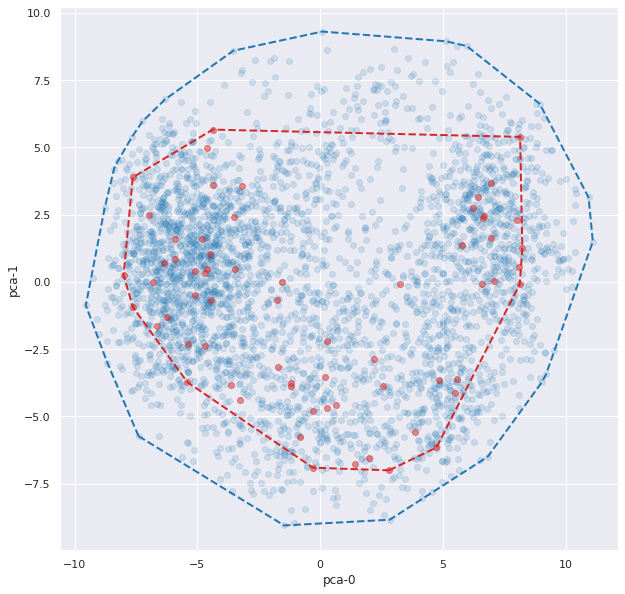

In [13]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
plot_hull('pca', ax1, '', document_pts, summary_pts[indices[m[0]][0]:indices[m[0]][1]])
plt.show()

In [ ]:
ray.shutdown()

2020-03-18 23:55:32,391	ERROR worker.py:998 -- Possible unhandled error from worker: ray::IDLE (pid=73126, ip=10.90.36.41)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/scratch/korunosk/conda-envs/dlab/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node iccluster111 is used (241.72 / 251.68 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
122163	22.48GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
94761	21.71GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
162429	21.67GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/shoaib/.local/share/jupyter/runtime/kernel-
38123	20.56GiB	/opt/anaconda3/bin/python -m ipykernel_launcher -f /home/gligoric/.local/share/jupyter/runtime/kerne
114612	20.08GiB	/

## Export embeddings

In [4]:
from config import *
from helpers import *

In [5]:
DATA_DIR = 'data'
EMBEDDINGS_DIR = os.path.join(DATA_DIR, 'fasttext')

In [6]:
from gensim.parsing.preprocessing import *
filters = [
    lambda s: s.lower(),
    strip_punctuation,
    strip_multiple_whitespaces,
    remove_stopwords,
]

In [7]:
vocab, embs = load_embeddings(os.path.join(EMBEDDINGS_DIR, 'crawl-300d-2M'))

In [18]:
def encode_words(documents):
    def encode(sentence):
        words = preprocess_string(sentence, filters)
        return [ list(embs[vocab[w]]) for w in words if w in vocab ]
    document_embs = []
    for document in documents:
        sentence_embs = []
        for sentence in document:
            sentence_embs.extend(encode(sentence))
        document_embs.append(sentence_embs)
    return document_embs

In [19]:
for dataset in DATASETS:
    print(dataset)
    data = load_data(DATA_DIR, dataset, encoded=False)
    for topic_id, topic in data.items():
        print('   {}'.format(topic_id))
        store_data(os.path.join(EMBEDDINGS_DIR, dataset), topic_id, make_topic(topic, encode_words))

TAC2008
   D0841
   D0804
   D0802
   D0809
   D0819
   D0825
   D0828
   D0826
   D0843
   D0829
   D0813
   D0807
   D0812
   D0820
   D0835
   D0823
   D0847
   D0848
   D0810
   D0822
   D0845
   D0844
   D0839
   D0814
   D0824
   D0821
   D0827
   D0846
   D0818
   D0834
   D0805
   D0817
   D0831
   D0815
   D0836
   D0806
   D0808
   D0837
   D0803
   D0830
   D0838
   D0840
   D0842
   D0832
   D0816
   D0801
   D0833
   D0811
TAC2009
   D0919
   D0904
   D0934
   D0928
   D0944
   D0917
   D0926
   D0921
   D0930
   D0907
   D0929
   D0913
   D0920
   D0909
   D0922
   D0935
   D0912
   D0903
   D0927
   D0940
   D0902
   D0925
   D0910
   D0931
   D0943
   D0939
   D0937
   D0933
   D0915
   D0941
   D0911
   D0924
   D0908
   D0932
   D0914
   D0916
   D0905
   D0923
   D0936
   D0938
   D0942
   D0918
   D0901
   D0906
